**Overview**

Machine learning for NLP practice

- Learning of word embeddings (based off pytorch tutorials)

In [170]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD, Adam

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [5]:
data_dir = "../data"

In [133]:
# Quick runthrough of how to use the nn.Embedding class to create an embedding for a limited vocab
# Establish a vocabulary, giving each word a specific index in your embedding
vocab = {"hello": 0, "world": 1}
# For each (2) word, create a n (10) dimensional embedding for it initialized with random balues
embed = nn.Embedding(2, 5) 
# Use torch.long (int64) as the indicies for the tensors are integers (smaller is probably fine too)
lookup_tensor = torch.tensor([vocab["hello"]], dtype=torch.long)
hello_embeds = embed(lookup_tensor)
print(hello_embeds)
# This works with longer word lookups too
t = torch.tensor([vocab["hello"], vocab["hello"], vocab["world"]], dtype=torch.long)
print(t)
print(embed(t.view(1, -1)))

tensor([[ 0.5314, -0.9057,  0.3006,  1.6123,  0.5813]])
tensor([ 0,  0,  1])
tensor([[[ 0.5314, -0.9057,  0.3006,  1.6123,  0.5813],
         [ 0.5314, -0.9057,  0.3006,  1.6123,  0.5813],
         [-1.3972, -0.9226,  0.2923,  1.1563, -0.8777]]])


In [134]:
# Size of the context (the 2-gram used to predict the third)
context_size = 2

embed_dim = 10

test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".lower().split()

# Compute trigrams for the entire sentence
trigrams = [(test_sentence[i], test_sentence[i + 1], test_sentence[i + 2]) for i in range(0, 
                                                                                          len(test_sentence) - 2,
                                                                                          3)]
print(trigrams[0:4])
vocab = {i: num for num, i in enumerate(set(test_sentence))}
print(f"Vocab is of length {len(vocab)}")

[('when', 'forty', 'winters'), ('shall', 'besiege', 'thy'), ('brow,', 'and', 'dig'), ('deep', 'trenches', 'in')]
Vocab is of length 90


In [135]:
class NGramModeler(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.l1 = nn.Linear(context_size * embed_dim, 128)
        self.l2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        # Input x is a tensor of ordered indices to our embeddings
        x = self.embeddings(x)
        # Convert from 2d structure to 1d for linear layer
        x = x.view(-1, 20)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [138]:
epochs = 100
net = NGramModeler(len(vocab), embed_dim, context_size)
# Note: Softmax is baked into the CEL. Don't add another softmax layer
criterion = nn.CrossEntropyLoss()
optim = SGD(net.parameters(), lr=0.005)
losses = []
for epoch in range(epochs):
    total_loss = 0
    for t1, t2, i in trigrams:
        # Prepare the input and test tensors
        context = (t1, t2)
        context_idxs = torch.tensor([[vocab[word] for word in context]], dtype=torch.long)
        ideal_idxs = torch.tensor([vocab[i]], dtype=torch.long)
        # Remove accumulated gradients
        optim.zero_grad()
        r = net(context_idxs)
        loss = criterion(r, ideal_idxs)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    losses.append(total_loss)
for i in losses:
    print(f"{i:.4f}")

tensor([[ 0.3606,  0.6116, -0.1506,  0.1175, -0.0736, -0.1801,  0.0815,
         -0.2727,  0.1266, -0.2601,  0.1236, -0.1916,  0.2747, -0.1771,
          0.1925, -0.2535, -0.1271,  0.0880, -0.4069,  0.5038,  0.0720,
          0.1127,  0.1776,  0.2393,  0.1534,  0.1786, -0.3929,  0.3150,
         -0.1845, -0.5183,  0.2326,  0.1481,  0.1841, -0.3688, -0.2352,
         -0.1185,  0.6948,  0.0108, -0.3021,  0.0348,  0.0219,  0.0603,
          0.1877, -0.5062,  0.0756, -0.4086,  0.2042,  0.2249,  0.0635,
         -0.0055, -0.2491,  0.1649,  0.3020,  0.0762, -0.0708, -0.3402,
          0.0835, -0.1662,  0.1646,  0.1887, -0.1756, -0.0146,  0.1595,
         -0.1558, -0.2326, -0.0799,  0.0873, -0.1419, -0.3294,  0.3439,
          0.4157,  0.0853, -0.3919,  0.0122, -0.1163, -0.1397, -0.2756,
         -0.0628, -0.0742, -0.2619, -0.2273,  0.2702,  0.1497, -0.0106,
          0.0790, -0.0687, -0.0016, -0.3414,  0.4049, -0.1857]]) tensor([ 53])


RuntimeError: No active exception to reraise

In [139]:
reverse_vocab = {num: word for word, num in vocab.items()}

In [ ]:
# Show that the training set was fit 
total = 0
errors = 0
input_vector = torch.tensor
for t1, t2, i in trigrams[:10]:
    # Prepare the input and test tensors
    context = (t1, t2)
    context_idxs = torch.tensor([[vocab[word] for word in context]], dtype=torch.long)
    res = F.softmax(net(context_idxs))
    print(res)
    val, index = torch.max(res, 0)
    index = index.item()
    print(i, reverse_vocab[index])

In [115]:
indata = [(vocab[i[0]], vocab[i[1]]) for i in trigrams[:2]]
print(trigrams[:2])

t = torch.tensor(indata[:2], dtype=torch.long)
vals, indices = torch.max(F.softmax(net(t)), 1)
for index, (t1, t2, ideal) in zip(indices, trigrams[:2]):
    print(f"Expected: {ideal}, got: {reverse_vocab[index.item()]}")
# print(t)
# e = net.embeddings(t)
# print(e)
# e = e.view(-1, 2 * embed_dim)
# print(e)
# print(e.shape)
# net.l1(e)

[('when', 'forty', 'winters'), ('shall', 'besiege', 'thy')]
Expected: winters, got: winters
Expected: thy, got: thy


C:\Users\h\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [124]:


t1, t2, i = trigrams[10]
context = (t1, t2)
context_idxs = torch.tensor([vocab[word] for word in context], dtype=torch.long)
context_idxs

print(net.embeddings(context_idxs))
net.embeddings(context_idxs).view(-1, 2, 10).sum(dim=1)

tensor([[-1.6936,  0.3130, -0.8321,  0.2499, -0.7003,  1.6888,  0.7946,
          1.2885, -0.4448,  0.1563],
        [-0.1937, -1.4294, -1.5171, -1.0318,  0.0356,  1.0939, -2.3710,
          0.8877,  0.2476,  0.4513]])


tensor([[-1.8873, -1.1165, -2.3492, -0.7820, -0.6646,  2.7827, -1.5764,
          2.1762, -0.1972,  0.6076]])

ValueError: too many values to unpack (expected 2)

In [26]:
a = torch.Tensor(list(range(24)))
print(a.view(-1, 3, 2))
print(a.view(-1, 3, 2).view(-1))

tensor([[[  0.,   1.],
         [  2.,   3.],
         [  4.,   5.]],

        [[  6.,   7.],
         [  8.,   9.],
         [ 10.,  11.]],

        [[ 12.,  13.],
         [ 14.,  15.],
         [ 16.,  17.]],

        [[ 18.,  19.],
         [ 20.,  21.],
         [ 22.,  23.]]])
tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
         10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
         20.,  21.,  22.,  23.])


**Bag of words model**

In [146]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])


class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim, context_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.f1 = nn.Linear(embed_dim, 128)
        self.f2 = nn.Linear(128, vocab_size)

    def forward(self, x):
        # sum the embeddings, removing the order from the data
        x = self.embed(x).sum(dim= 1)
        x = F.relu(self.f1(x))
        x = self.f2(x)
        return x

cbow = CBOW(vocab_size, 10, 2)
optim = SGD(cbow.parameters(), 0.01)
criterion = nn.CrossEntropyLoss()
# create your model and train.  here are some functions to help you make
# the data ready for use by your module
EPOCHS = 40
for epoch in range(EPOCHS):
    total_loss = 0
    for context, ideal in data:
        context_vector = make_context_vector(context, word_to_ix).view(-1 , 4)
        ideal_vector = torch.tensor(word_to_ix[ideal], dtype=torch.long).view(1)
        optim.zero_grad()
        res = cbow(context_vector)
#         print(res)
#         print(ideal_vector)
        loss = criterion(res, ideal_vector)
        loss.backward()
        optim.step()
        total_loss += loss.item()
    print(total_loss)
        
        
    


def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]
235.06018900871277
197.16198062896729
170.28847336769104
148.16921374201775
129.40116673707962
113.04026806354523
98.60923334956169
85.78385156393051
74.42276632785797
64.46674011647701
55.797726690769196
48.336279183626175
41.97023555636406
36.557565569877625
31.946965888142586
28.049244225025177
24.722156293690205
21.88813839107752
19.455124586820602
17.363011691719294
15.554624313488603
13.989160234108567
12.63008351251483
11.457808109000325
10.433925556018949
9.541058376431465
8.762558622285724
8.086411471478641
7.491235591471195
6.964336744509637
6.499313586391509
6.085830337833613
5.715366017539054
5.381845075637102
5.0813878695480525
4.80943167489022
4.562669163569808
4.336041197180748
4.12948216823861
3.940782212652266


tensor([ 20,  30,   2,  23])

Now, let's visualize the embeddings we've pulled out for any clustering

Dimensionality reduction using TSNE on the 10 dimensional text embedding, and dumping it into 2d space

In [179]:
def get_embedding(index, embeddings):
    return embeddings(torch.tensor(index, dtype=torch.long)).detach().numpy()

embeddings = cbow.embed

word_embeddings = {word: get_embedding(index, embeddings) for word, index in word_to_ix.items()}
embedding_matrix = np.matrix([get_embedding(index, embeddings) for index in range(len(word_to_ix))])
tsne = TSNE()
transformed = tsne.fit_transform(embedding_matrix)
word_transformed = [(ix_to_word[i], transformed[i][0], transformed[i][1]) for i in range(len(word_to_ix))]

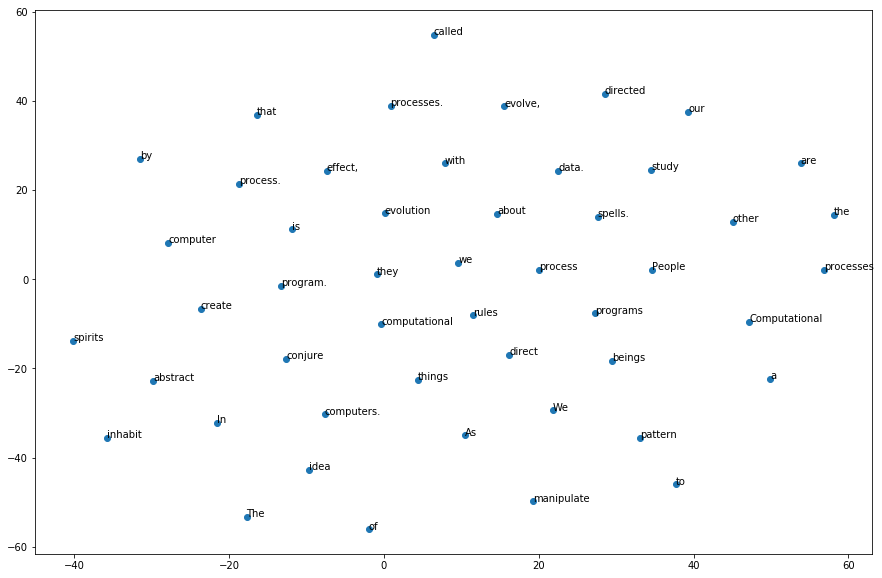

In [188]:
plt.figure(1, (15, 10))
plt.scatter(*zip(*[(i[1], i[2]) for i in word_transformed]))
for word, x, y in word_transformed:
    plt.annotate(word, (x, y))
plt.show()

In [178]:
transformed[0][1]

11.809801

In [180]:
word_transformed

[('about', 14.6152315, 14.637125),
 ('spirits', -40.10351, -13.83777),
 ('to', 37.71747, -45.91523),
 ('we', 9.60317, 3.7019167),
 ('inhabit', -35.747513, -35.543373),
 ('direct', 16.18105, -16.882576),
 ('things', 4.42552, -22.537237),
 ('spells.', 27.618078, 13.994449),
 ('of', -1.9495914, -56.004707),
 ('program.', -13.302757, -1.4166546),
 ('process.', -18.713032, 21.382967),
 ('directed', 28.517097, 41.53819),
 ('processes.', 0.86190397, 38.833744),
 ('conjure', -12.595264, -17.865507),
 ('As', 10.437628, -35.009754),
 ('People', 34.587242, 2.0688527),
 ('idea', -9.637466, -42.671764),
 ('computer', -27.846123, 8.162039),
 ('process', 20.025553, 2.1315796),
 ('In', -21.55695, -32.15341),
 ('We', 21.835176, -29.319872),
 ('computers.', -7.6403527, -30.321974),
 ('create', -23.635391, -6.5690546),
 ('study', 34.525448, 24.581846),
 ('evolution', 0.13440825, 14.759117),
 ('rules', 11.467225, -8.087008),
 ('that', -16.407228, 36.895695),
 ('called', 6.4196477, 54.749706),
 ('manipulat